Korelacje ze zmienną celu:
 int_rate           0.206412
dti                0.154905
loan_amnt          0.087145
open_acc           0.057344
installment        0.047264
emp_length         0.016614
revol_util        -0.000819
delinq_2yrs       -0.016380
annual_inc        -0.084425
fico_range_high   -0.094199
dtype: float64


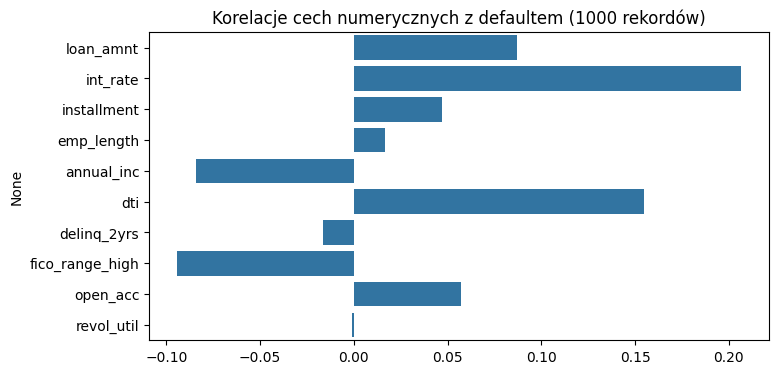

['processed_data.pkl']

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Wybór kolumn
cols = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership',
    'annual_inc', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_high', 'open_acc',
    'revol_util', 'loan_status'
]

# Wczytaj tylko 5000 wierszy
df = pd.read_csv("accepted_2007_to_2018Q4.csv", usecols=cols, nrows=5000)

# Binaryzacja zmiennej celu
df['default'] = df['loan_status'].apply(lambda x: 1 if 'Charged Off' in str(x) else 0)

# Czyszczenie kolumn
df['emp_length'] = df['emp_length'].str.extract(r'(\d+)').astype(float).fillna(0)
df['revol_util'] = df['revol_util'].astype(str).str.replace('%', '', regex=False).astype(float)

# Usuwamy NaN
df.dropna(subset=['int_rate', 'annual_inc', 'emp_length', 'fico_range_high', 'revol_util'], inplace=True)

# ➕ OGRANICZ DO 1000 losowych obserwacji po oczyszczeniu
df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Korelacja – tylko numeryczne
numeric = df.select_dtypes(include=[np.number]).drop(columns='default')
corrs = numeric.corrwith(df['default'])

# Wyświetl korelacje
print("Korelacje ze zmienną celu:\n", corrs.sort_values(ascending=False))

# Wykres korelacji
plt.figure(figsize=(8, 4))
sns.barplot(x=corrs.values, y=corrs.index)
plt.title("Korelacje cech numerycznych z defaultem (1000 rekordów)")
plt.show()

# Wybór cech do modelu
selected_numeric = ['loan_amnt', 'int_rate', 'annual_inc', 'emp_length', 'fico_range_high', 'revol_util']
selected_categorical = ['purpose', 'home_ownership']

X_raw = df[selected_numeric + selected_categorical]
y = df['default'].values

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), selected_numeric),
    ('cat', OneHotEncoder(drop='first'), selected_categorical)
])

X_processed = preprocessor.fit_transform(X_raw)

feature_names = (
    selected_numeric +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(selected_categorical))
)

X = X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed

joblib.dump((X, y, df['purpose']), "processed_data.pkl")
